In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

In [165]:
def format_by_sigma(x, sigma_x):
    exp = 0
    while not 1 < np.abs(sigma_x) < 10:
        if np.abs(sigma_x) < 10:
            sigma_x *= 10
            exp += 1
        else:
            sigma_x /= 10
            exp += 1
    x = x * np.pow(10, exp)
    fmt = "{:.0f}"
    return x, sigma_x, fmt, exp

In [248]:
sigma_phi = 1       # делений
sigma_lambda = 0.5  # A

In [3]:
grad_data = pd.read_excel("data.xlsx", engine="openpyxl", sheet_name="grad")
grad_data.head()

,lambda,phi,material
0,5331,1834,Ne
1,5341,1842,Ne
2,5401,1884,Ne
3,5852,2145,Ne
4,5882,2158,Ne


# Пункт 1


Аппроксимация градуировочной кривой:
$$ \lambda (\varphi) = \lambda_0 + \cfrac{C}{\varphi - \varphi_0} $$

Погршеность:
$$\sigma_\lambda = \sqrt{\left( \cfrac{\partial \lambda}{\partial \lambda_0}\right)^2 \sigma_{\lambda_0}^2 + \left(\cfrac{\partial \lambda}{\partial C}\right)^2 \sigma_{C}^2 + \left( \cfrac{\partial \lambda}{\partial \varphi_0}\right)^2\sigma_{\varphi_0}^2 + \left( \cfrac{\partial \lambda}{\partial \varphi}\right)^2 \sigma_{\varphi}^2} = \sqrt{\sigma_{\lambda_0}^2 + \left(\cfrac{\lambda - \lambda_0}{C}\right)^2 \sigma_{C}^2 + \left( \cfrac{\lambda - \lambda_0}{\varphi - \varphi_0}\right)^2 (\sigma_{\varphi_0}^2 + \sigma_{\varphi}^2) } $$

In [181]:
def lambda_func(x, lambda0, x0, c):
    return lambda0 + c / (x - x0)

In [182]:
def lambda_sigma_func(x, sigma_x, params, param_errs):
    lambda0, x0, c = params
    sigma_lambda0, sigma_x0, sigma_c = param_errs
    return np.sqrt(
        sigma_lambda0**2  + 
        np.square((x - lambda0) / c) * sigma_c**2 + 
        np.square((x - lambda0) / (x - x0)) * (sigma_x**2 + sigma_x0)
    )

Параметры
lambda_0 = (23826 +- 2) * 10^1
varphi_0 = (3880 +- 9) * 10^0
c        = (-60245052380 +- 7) * 10^4


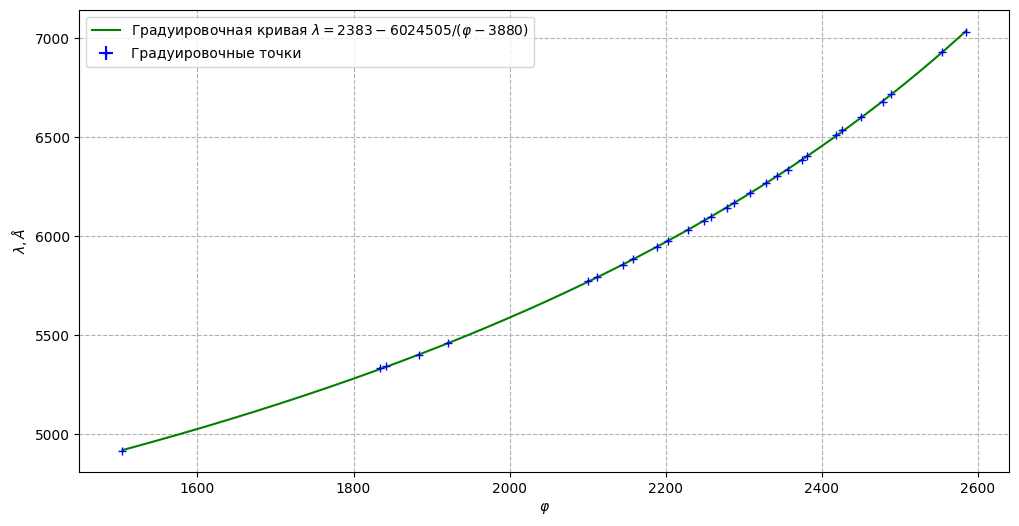

In [183]:
x = grad_data["phi"]
y = grad_data["lambda"]
dots_xy = list(zip(x, y))
dots_xy.sort(key=(lambda x: x[0]))
x_data, y_data = [], []
for x_, y_ in dots_xy:
    x_data.append(x_)
    y_data.append(y_)


popt, pcov = curve_fit(lambda_func, x_data, y_data, p0=(2000, 4000, -7000000), maxfev=1000)

popt_err = np.sqrt(np.diag(pcov))
popt_fmts = []
names = ["lambda_0", "varphi_0", "c       "]
print("Параметры")
for i in range(len(popt)):
    param, param_err, fmt, exp = format_by_sigma(popt[i], popt_err[i])
    print(f"{names[i]} = ({fmt.format(param)} +- {fmt.format(param_err)}) * 10^{exp}")


x_model = np.linspace(min(x_data), max(x_data), 10000)
y_model = lambda_func(x_model, *popt)

plt.figure(figsize=(12, 6))

plt.plot(x_model, y_model, "g", label=rf"Градуировочная кривая $\lambda = {popt[0]:.0f} {popt[2]:.0f} / (\varphi - {popt[1]:.0f})$")
plt.errorbar(grad_data["phi"], grad_data["lambda"], xerr=sigma_phi, yerr=sigma_lambda, fmt="+b", label="Градуировочные точки")


plt.grid(True, linestyle='--')
plt.ylabel(r"$\lambda, \AA$")
plt.xlabel(r"$\varphi$")

plt.legend()
plt.show()

# Пункт 2

In [216]:
data_H = pd.read_excel("data.xlsx", engine="openpyxl", sheet_name="H")

In [217]:
# Константа для перевода м -> эВ
c = np.float128('3e8')
h = np.float128('6.6e-34')
e = np.float128('1.6e-19')
const = h * c / e

In [218]:
data_H["lambda"] = lambda_func(data_H["phi"], *popt)
data_H["sigma_lambda"] = lambda_sigma_func(data_H["phi"], sigma_phi, popt, popt_err)

In [219]:
data_H

,H линия,цвет,phi,n,lambda,sigma_lambda
0,alpha,красный,2440.0,3,6567.309348,20.437091
1,beta,Зелено-голубая,1450.0,4,4862.180395,23.019594
2,gamma,Фиолетово-синяя,820.0,5,4351.619759,27.054641
3,delta,фиолетовая,NaN,6,NaN,NaN


# Пункт 3

$$ \cfrac{1}{\lambda_{mn}} = R Z^2 \left( \cfrac{1}{n^2} - \cfrac{1}{m^2} \right) \implies \cfrac{\lambda_{m_1 n}}{\lambda_{m_2 n}} = \cfrac{1 - \cfrac{n^2}{m_1^2}}{1 - \cfrac{n^2}{m_2^2}} $$

In [220]:
ms = ["3", "4", "5"]
lambdas_fracs = pd.DataFrame(columns=[" ", "3", "4", "5"])
lambdas_fracs[" "] = ms
for m in ms:
    lambdas_fracs[m] = data_H.loc[int(m) - 3, "lambda"] / data_H["lambda"]
lambdas_fracs

,,3,4,5
0,3,1.000000,0.740361,0.662618
1,4,1.350692,1.000000,0.894993
2,5,1.509164,1.117327,1.000000


In [221]:
m_fracs = pd.DataFrame(columns=[" ", "3", "4", "5"])
m_fracs[" "] = ms
for m1 in ms:
    for m2 in ms:
        val = (1 - 4 / int(m2)**2) / (1 - 4 / int(m1)**2)
        m_fracs.loc[int(m2) - 3, m1] = val
m_fracs

,,3,4,5
0,3,1.0,0.740741,0.661376
1,4,1.35,1.0,0.892857
2,5,1.512,1.12,1.0


Соотношения выполняются.

# Пункт 4

$$ R = \cfrac{1}{\lambda_m} \left(\cfrac{1}{4} - \cfrac{1}{m^2}\right)^{-1} $$

Погрешность:

$$ \sigma_R = \left| \cfrac{\partial R}{\partial \lambda_m} \right| \sigma_{\lambda_m} = R \cfrac{\sigma_{\lambda_m}}{\lambda_m}  $$

In [ ]:
data_H["R"] = 1/ (data_H["lambda"] / 1e10) / (0.25 - 1 / data_H["n"]**2)
data_H["sigma_R"] = data_H["R"] * data_H["sigma_lambda"] / data_H["lambda"]

data_H["R_ev"] = data_H["R"] * const
data_H["sigma_R_ev"] = data_H["sigma_R"] * const
data_H

,H линия,цвет,phi,n,lambda,sigma_lambda,R,sigma_R,R_ev,sigma_R_ev
0,alpha,красный,2440.0,3,6567.309348,20.437091,1.096339e+07,34117.454962,13.567200,0.042220
1,beta,Зелено-голубая,1450.0,4,4862.180395,23.019594,1.096902e+07,51931.905421,13.574157,0.064266
2,gamma,Фиолетово-синяя,820.0,5,4351.619759,27.054641,1.094283e+07,68033.154020,13.541756,0.084191
3,delta,фиолетовая,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN


# Пункт 5

In [223]:
data_I = pd.read_excel("data.xlsx", engine="openpyxl", sheet_name="I")

In [225]:
data_I["lambda"] = lambda_func(data_I["phi"], *popt)
data_I["sigma_lambda"] = lambda_sigma_func(data_I["phi"], sigma_phi, popt, popt_err)
data_I

,n,phi,lambda,sigma_lambda
0,"h_nu_1,0",2235,6045.698817,20.496448
1,h_nu_1.5,2128,5821.937139,20.633440
2,h_nu_гр,2262,6106.839252,20.473233


# Пункт 6

In [229]:
data_I["h_nu"] = 1240 / (data_I["lambda"] / 10)
data_I["sigma_h_nu"] = data_I["h_nu"] * data_I["sigma_lambda"] / data_I["lambda"]
data_I

,n,phi,lambda,sigma_lambda,h_nu,sigma_h_nu
0,"h_nu_1,0",2235,6045.698817,20.496448,2.051045,0.006954
1,h_nu_1.5,2128,5821.937139,20.633440,2.129875,0.007548
2,h_nu_гр,2262,6106.839252,20.473233,2.030510,0.006807


In [232]:
h_nu_10, h_nu_15, h_nu_border = data_I["h_nu"]
sigma_h_nu_10, sigma_h_nu_15, sigma_h_nu_border = data_I["sigma_h_nu"]

h_nu_2 = (h_nu_15 - h_nu_10) / 5
sigma_h_nu_2 = 0.2 * np.sqrt(sigma_h_nu_15 ** 2 + sigma_h_nu_10 ** 2)

print(f"h_nu_2 = ({h_nu_2:.3f} +- {sigma_h_nu_2:.3f}) eV")

h_nu_2 = (0.016 +- 0.002) eV


# Пункт 7

### Пункт а

$$ h \nu_{0, n_2} = \left(E_2 - E_1\right) + h \nu_2 \left( n_2 + \cfrac{1}{2} \right) - \cfrac{1}{2} h \nu_1 $$


Тогда
$$ h \nu_\text{эл} = h \nu_{1,0} - \cfrac{1}{2}h \nu_2 + \cfrac{3}{2} h \nu_1 $$

Погрешность:

$$ \sigma_{h \nu} = \sqrt{ \sigma_{h \nu_{1,0}}^2 + \cfrac{1}{4} \sigma_{h \nu_2}^2 + \cfrac{9}{4} \sigma_{h \nu_1}^2 } $$

In [246]:
h_nu_1 = 0.027          # eV
sigma_h_nu_1 = 0.0005   # eV

h_nu_el = h_nu_10 - 0.5 * h_nu_2 + 1.5 * h_nu_1
sigma_h_nu_el = np.sqrt(sigma_h_nu_10**2 + 0.25 * sigma_h_nu_2**2 + 2.25 * sigma_h_nu_1**2)
print(f"h nu_el = ({h_nu_el:.2f} +- {sigma_h_nu_el:.2f}) eV")

h nu_el = (2.08 +- 0.01) eV


### Пункт б

$$ D_1 = h \nu_\text{гр} - E_A$$

$$ \sigma_{D_1} = \sqrt{\sigma_{h \nu_\text{гр}}^2 + \sigma_{E_A}^2} $$

In [245]:
E_A = 0.94          # eV
sigma_E_A = 0.005   # eV

D_1 = h_nu_border - E_A
sigma_D_1 = np.sqrt(sigma_h_nu_border**2 + sigma_E_A**2)
print(f"D_1 = ({D_1:.2f} +- {sigma_D_1:.2f}) eV")

D_1 = (1.09 +- 0.01) eV


### Пункт в

$$ D_2 = h \nu_\text{гр} - h \nu_\text{эл} $$

$$ \sigma_{D_2} = \sqrt{\sigma_{h \nu_\text{гр}}^2 + \sigma_{h \nu_\text{эл}}^2} $$

In [247]:
D_2 = h_nu_border - h_nu_el
sigma_D_2 = np.sqrt(sigma_h_nu_border**2 + sigma_h_nu_el**2)
print(f"D_2 = ({D_2:.2f} +- {sigma_D_2:.2f}) eV")

D_2 = (-0.05 +- 0.01) eV
